In [1]:
conda env list

# conda environments:
#
NewEnv                   /home/achartra/.conda/envs/NewEnv
PINNICLEenv           *  /home/achartra/.conda/envs/PINNICLEenv
allison                  /home/achartra/.conda/envs/allison
baseclone                /home/achartra/.conda/envs/baseclone
base                     /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05
earthml                  /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/earthml
esmvaltool               /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/esmvaltool
gdalNgmt                 /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/gdalNgmt
ilab-pytorch             /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/ilab-pytorch
ilab-tensorflow          /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/ilab-tensorflow
ml                       /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhe

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-12-20 09:32:44.084065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 09:32:45.516221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734705165.771418  993479 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734705165.846337  993479 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 09:32:46.826234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [2]:
# Testing PINNICLE
# Infer basal friction coefficients using SSA

import pinnicle as pinn
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from datetime import datetime

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Disable just-in-time compilation with XLA.


Set the default float type to float64


In [2]:
# Load the correct data

issm_filename = "Ryder_test_I19-Dec-2024_3"
datestr = datetime.now().strftime("%d-%b-%y")

issm_pinn_path = issm_filename + "_P" + datestr + "_2"
# General parameters for training
# Setting up dictionaries
# order doesn't matter, but keys DO matter
hp = {}

# Load data ? 
# In data_size, each key:value pair defines a variable in the training. 
# if the key is not redefined in name_map, then it will be used as default 
# or set in the physics section above. The value associated with the key 
# gives the number of data points used for training.
# If the value is set to None, then only Dirichlet BC around the domain 
# boundary will be used for the corresponding key. If the variable is included
# in the training, but not given in data_size, then there will be no data for this variable in the training
flightTrack = {}
flightTrack["data_path"] = "./Ryder_xyz_ds.mat"
flightTrack["data_size"] = {"H": 20000}
flightTrack["name_map"] = {"H": "thickness"}
flightTrack["X_map"] = {"x": "x", "y":"y"}
flightTrack["source"] = "mat"
hp["data"] = {"ft": flightTrack}

issm = {}
issm["data_path"] = "./Models/" + issm_filename + ".mat"
issm["data_size"] = {"u":10000, "v":10000, "s":10000, "H":None, "C":10000, "B":10000}
hp["data"] = {"ISSM":issm, "ft":flightTrack} # hp = 'hyperparameters'

hp["epochs"] = int(5e4)
hp["learning_rate"] = 0.0005
hp["loss_function"] = "MSE"
hp["save_path"] = "./PINNs/" + issm_pinn_path
hp["is_save"] = True
hp["is_plot"] = True

# Set NN architecture
hp["activation"] = "tanh"
hp["initializer"] = "Glorot uniform"
hp["num_neurons"] = 20
hp["num_layers"] = 6
hp["input"] = ['y', 'x']

# Define domain of computation
hp["shapefile"] = "./Ryder_32_09.exp"
# Define number of collocation points used to evaluate PDE residual
hp["num_collocation_points"] = 20000

# Add physics
yts = pinn.physics.Constants().yts
SSA = {}
SSA["scalar_variables"] = {"B":2e+08, "n":3} # -20 deg C
                    # u                     v                 s        H      C        B
SSA["data_weights"] = [(1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, 5.0e-6, 5.0e-6, 5.0e-8, 1e-16]
# hp["equations"] = {"SSA":{"input":["x1", "x2"]}}
hp["equations"] = {"SSA_VB":SSA}

# MOLHO = {}
# MOLHO["scalar_variables"] = {"B":2e+08}
# hp["equations"] = {"MOLHO":MOLHO}
#                     #        u                 v                u_base               v_base            s        H      C
# MOLHO["data_weights"] = [(1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, 1.0e-6, 1.0e-6, 1.0e-8]

hp['fft'] = True
hp['sigma'] = 5
hp['num_fourier_feature'] = 30

# Add an additional loss function to balance the contributions between the fast flow and slow moving regions:
# vel_loss = {}
# vel_loss['name'] = "vel log"
# vel_loss['function'] = "VEL_LOG"
# vel_loss['weight'] = 1.0e-5
# hp["additional_loss"] = {"vel":vel_loss}

experiment = pinn.PINN(hp) # set up class PINN (in pinn.py in pinnicle package)
# experiment.update_parameters(hp)
print(experiment.params) # make sure that settings are in correct spot (keys must be correct)

ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add Fourier feature transform to input transform
add output transform with [-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02  7.0000000e+07] and [3.1709792e-04 3.1709792e-04 3.6000000e+03 3.5000000e+03 1.0000000e+04
 7.0000000e+08]
Parameters: 
	TrainingParameter: 
		epochs:	50000
		optimizer:	adam
		loss_functions:	['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE']
		additional_loss:	{}
		learning_rate:	0.0005
		loss_weights:	[1e-10, 1e-10, 99451929600.0, 99451929600.0, 5e-06, 5e-06, 5e-08, 1e-16]
		has_callbacks:	False
		min_delta:	None
		patience:	None
		period:	None
		checkpoint:	False
		save_path:	./PINNs/Ryder_test_I19-Dec-2024_3_P20-Dec-24_2
		is_save:	True
		is_plot:	True
	DomainParameter: 
		shapefile:	./Ryder_32_09.exp
		num_collocation_points:	20000
		time_dependent:	False
		start_time:	0
		end_time:	0
	DataParameter: 
		ISSM:
			data_path:	./Models/Ryder_test_I19-Dec-2024_3.mat
			data_size:	{'u': 10000, 'v': 10000, 's': 10000, 'H': None, 'C

2024-12-20 13:18:45.643139: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1734718725.643362 1093962 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


In [ ]:
# Now run the PINN model
experiment.compile()

# Train
experiment.train()
# Show results
experiment.plot_predictions(X_ref=experiment.model_data.data["ISSM"].X_dict, sol_ref=experiment.model_data.data["ISSM"].data_dict)

# Save results 
import hdf5storage
import scipy


resolution = 200
    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], resolution),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], resolution))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
plot_data = {k+"_pred":np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}

mat_data = {} # make a dictionary to store the MAT data in
vars2save = ['sol_pred','X_nn']
for i, var_curr in enumerate(vars2save):
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')
 
hdf5storage.savemat(hp["save_path"] + '/' + issm_pinn_path + '_predictions.mat', mat_data, format='7.3', oned_as='row', store_python_metadata=True)

In [66]:
# print(len(experiment.model_data.X['C']))
# print(len(experiment.model_data.X['H']))
# print(experiment.model_data.sol)
# print(experiment.params.param_dict['B'])
print(vars(experiment.params.physics))

{'param_dict': {'data': {'ISSM': {'data_path': './Models/Ryder_test_I05-Dec-2024_2.mat', 'data_size': {'u': 5000, 'v': 5000, 's': 5000, 'H': None, 'C': 5000, 'vel': 5000}}, 'ft': {'data_path': './Ryder_xyz.mat', 'data_size': {'H': 8000}, 'name_map': {'H': 'thickness'}, 'X_map': {'x': 'x', 'y': 'y'}, 'source': 'mat'}}, 'epochs': 100000, 'learning_rate': 0.0005, 'loss_function': 'MSE', 'save_path': './PINNs/Ryder_test_I05-Dec-2024_2_P16-Dec-24_2', 'is_save': True, 'is_plot': True, 'activation': 'tanh', 'initializer': 'Glorot uniform', 'num_neurons': 20, 'num_layers': 6, 'input': ['y', 'x'], 'shapefile': './Ryder_32_09.exp', 'num_collocation_points': 10000, 'equations': {'SSA': {'scalar_variables': {'B': 200000000.0, 'n': 4}, 'data_weights': [99451929600.0, 99451929600.0, 5e-06, 1e-06, 1e-08]}}, 'fft': True, 'sigma': 5, 'num_fourier_feature': 30, 'B': [[6.605542387359734, 1.1229533305596202, 7.43116665398821, -3.535552712628588, 1.424607792835342, -0.7693938490405215, 2.957133272478977, -

**Below this is old and unpolished code for playing around**

In [4]:
# How to print different sections of model
# print(experiment.params.training)

# print(experiment.params.nn.output_lb)
# print(experiment.model.predict)

import deepxde.backend as bkd

resolution = 200
    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], resolution),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], resolution))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
grid_size = 2.0*(((experiment.params.nn.input_ub[0] - experiment.params.nn.input_lb[0])/resolution)**2+
                 ((experiment.params.nn.input_ub[1] - experiment.params.nn.input_lb[1])/resolution)**2)**0.5
if bkd.backend_name == "pytorch":
    grid_size = bkd.to_numpy(grid_size)

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
plot_data = {k+"_pred":np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}


[-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02]
<bound method Model.predict of <deepxde.model.Model object at 0x1504e5075630>>


In [5]:
import hdf5storage
import scipy
 
mat_data = {} # make a dictionary to store the MAT data in
vars2save = ['sol_pred','X_nn']
for i, var_curr in enumerate(vars2save):
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')
 
hdf5storage.savemat(hp["save_path"] + '/' + issm_pinn_path + '_predictions.mat', mat_data, format='7.3', oned_as='row', store_python_metadata=True)

2025-01-10 16:59:12.935495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736546352.962985 3440527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736546352.971411 3440527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 16:59:13.025324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples

Set the default float type to float64


ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add Fourier feature transform to input transform
add output transform with [-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02  7.0000000e+07] and [3.1709792e-04 3.1709792e-04 3.6000000e+03 3.5000000e+03 1.0000000e+04
 7.0000000e+08]
Compiling model...
'compile' took 0.007787 s

Compiling model...
'compile' took 0.003448 s



NameError: name 'hp' is not defined

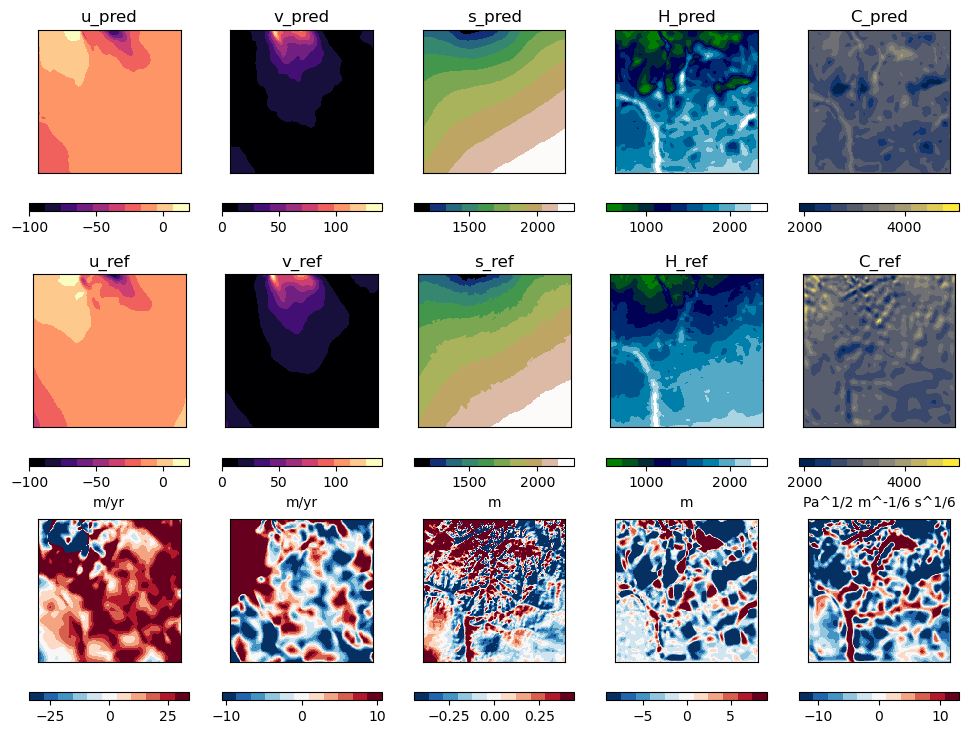

In [1]:
import pinnicle as pinn
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from datetime import datetime

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)

## Load settings from previous experiment
experiment = pinn.PINN(loadFrom="./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-10_2G")

# new_folder = './PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-09-1La'
# experiment.update_parameters({"save_path": new_folder})

## Load weights from previously trained NN
experiment.load_model(path="./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-10_2G")


# Plotting

import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib as mpl
import deepxde.backend as bkd
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
from scipy.spatial import cKDTree as KDTree
import scipy.io as sio
import pandas as pd
from scipy.stats import iqr

resolution = 150

    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], resolution),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], resolution))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

X_ref=experiment.model_data.data["ISSM"].X_dict
X_ref = np.hstack((X_ref['x'].flatten()[:,None],X_ref['y'].flatten()[:,None]))

# predicted solutions
sol_pred = experiment.model.predict(X_nn)

sol_ref=experiment.model_data.data["ISSM"].data_dict
ref_data = {k:griddata(X_ref, sol_ref[k].flatten(), (X, Y), method='cubic') for k in experiment.params.nn.output_variables if k in sol_ref}

del ref_data['B']

pred_data = {k:np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}
vranges = {k+"_pred":[experiment.params.nn.output_lb[i], experiment.params.nn.output_ub[i]] for i,k in enumerate(experiment.params.nn.output_variables)}

ref_names = ref_data.keys()
data_names = pred_data.keys()
yts = 31536000.0

ref_data["u"] = yts*ref_data["u"]
ref_data["v"] = yts*ref_data["v"]

pred_data["u"] = yts*pred_data["u"]
pred_data["v"] = yts*pred_data["v"]
# pred_data["u_base"] = yts*pred_data["u_base"]
# pred_data["v_base"] = yts*pred_data["v_base"]


cranges = {name:[np.round(np.min(ref_data[name]),decimals=-1), np.round(np.max(ref_data[name]),decimals=-1)] for name in ref_names}
# cranges["u_base"] = cranges["u"]
# cranges["v_base"] = cranges["v"]

clabels = {name:[] for name in ref_names}
clabels["u"] = "m/yr"
clabels["v"] = "m/yr"
clabels["s"] = "m"
clabels["C"] = "Pa^1/2 m^-1/6 s^1/6"
clabels["H"] = "m"

cmaps = {name:[] for name in ref_names}
cmaps["u"] = plt.get_cmap("magma", 10)
cmaps["v"] = plt.get_cmap("magma", 10)
cmaps["s"] = plt.get_cmap("gist_earth", 10)
cmaps["C"] = plt.get_cmap("cividis", 10)
cmaps["H"] = plt.get_cmap("ocean", 10)

perc_diff = {name:((pred_data[name] - ref_data[name])/ref_data[name])*100 for name in ref_names}
q75_pd = {name:np.quantile(np.abs(perc_diff[name]),0.75) for name in ref_names}
cranges_pd = {name:[-1*q75_pd[name], q75_pd[name]] for name in ref_names}
# cranges_pd = {name:[-np.round(np.max(np.abs(perc_diff[name])), decimals=-1), np.round(np.max(np.abs(perc_diff[name])), decimals=-1)] for name in ref_names}

n = len(ref_data)
# if cols is None:
cols = len(ref_names)

# fig, axs = plt.subplots(math.ceil(n/cols), cols, figsize=(12,9))
# for ax, name in zip(axs.ravel(), ref_data.keys()):
fig, axs = plt.subplots(3, cols, figsize=(12,9))
for ax, name in zip(axs[0], ref_data.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(pred_data[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   origin='lower', aspect='equal')
    ax.set_title(name+"_pred")
    ax.tick_params(left = False, right = False , labelleft = False , 
                   labelbottom = False, bottom = False)
    fig.colorbar(im, ax=ax, location="bottom")

# fig, axs = plt.subplots(math.floor(n/cols), cols, figsize=(12,9))
for ax, name in zip(axs[1], ref_data.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(ref_data[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.set_title(name+"_ref")
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    fig.colorbar(im, ax=ax, label=clabels[name], fraction=0.1, orientation="horizontal", location="bottom") 
    
# fig, axs = plt.subplots(math.floor(n/cols), cols, figsize=(12,9))
for ax, name in zip(axs[2], ref_data.keys()):
    vr = cranges_pd.setdefault(name, [None, None])
    im = ax.imshow(perc_diff[name], interpolation='nearest', cmap=plt.get_cmap('RdBu_r',11),
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    fig.colorbar(im, ax=ax, orientation="horizontal", location="bottom") 

plt.savefig(experiment.params.param_dict["save_path"]+"/2Dsolutions_1")

In [4]:
# from pinnicle.utils.plotting import plot_solutions
from pinnicle.utils.history import load_dict_from_json

# Plot Loss History on one axis
# plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
# loss_keys = [k for k in self.history.keys() if k != "steps"]
# n = len(loss_keys)   

# fig, axs = plt.subplots(math.ceil(n/cols), cols, figsize=(16,12))

# for ax, name in zip(axs.ravel(), loss_keys):
#     ax.plot((self.history[name]), label=name)
#     ax.axes.set_yscale('log')
#     ax.legend(loc="best")


experiment.history = load_dict_from_json("./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-10_2G","history.json")

loss_keys = [k for k in experiment.history.keys() if k != "steps"]
print(loss_keys)
# for name in loss_keys:
#     plt.plot(experiment.history[name], label=name)

plt.plot(experiment.history['fSSA 1'], "k-", label="SSA PDE 1", linewidth=3)
plt.plot(experiment.history['fSSA 2'], label="SSA PDE 
# plt.plot(experiment.history['fMOLHO 1'], "k-", label="MOLHO PDE 1", linewidth=3)
# plt.plot(experiment.history['fMOLHO 2'], label="MOLHO PDE 2", linestyle="-", c='0.4', linewidth=3)
# plt.plot(experiment.history['fMOLHO base 1'], "k--", label="MOLHO base PDE 1", linewidth=3)
# plt.plot(experiment.history['fMOLHO base 2'], label="MOLHO base PDE 2", linestyle="--",linewidth=3, c='0.4')

plt.plot(experiment.history['u'], label='Surface velocity (x-component)', linewidth=6, c=[0.85,0.33,0.10])
plt.plot(experiment.history['v'], label='Surface velocity (y-component)', linewidth=6, c=[0.69,0.16,0.69])
plt.plot(experiment.history['s'], label='Surface elevation', linewidth=8, c=[0.58,0.39,0.39])
plt.plot(experiment.history['H'], label='Ice thickness', linewidth=6, c='g', linestyle=":")
plt.plot(experiment.history['C'], label='Basal friction coefficient', linewidth=5, linestyle="-.", c=[0.30,0.75,0.93])

plt.legend(loc="best")
plt.yscale('log')
plt.xlabel('Steps (*10^4)')
plt.ylabel('Loss function value')
plt.savefig(experiment.params.param_dict["save_path"]+"/history_plot")

['fSSA_VB1', 'fSSA_VB2', 'u', 'v', 's', 'H', 'C', 'B']


KeyError: 'fMOLHO 1'